In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text
from dateutil.relativedelta import relativedelta

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()


In [6]:
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys() 

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(text("date DESC")).first()

('2017-08-23',)

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent = session.query(measurement.date).order_by(text("date DESC")).first()

# Calculate the date one year from the last date in data set.
latest_date = pd.to_datetime(most_recent[0]).date()
one_year_ago = latest_date - relativedelta(years=1)
one_year_ago = str(one_year_ago)
one_year_ago 

'2016-08-23'

In [12]:
# Perform a query to retrieve the data and precipitation scores
prcp_data = (session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).order_by(measurement.date).all())

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_data)
prcp_df

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02
...,...,...
2225,2017-08-22,0.50
2226,2017-08-23,0.00
2227,2017-08-23,0.00
2228,2017-08-23,0.08


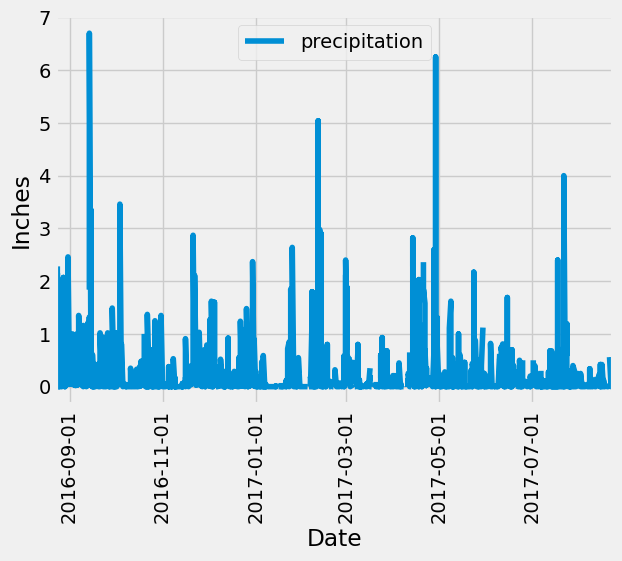

In [21]:

# Sort the dataframe by date
prcp_df["date"] = pd.to_datetime(prcp_df["date"]).dt.date
prcp_df = prcp_df.sort_values(by="date")

# Use Pandas Plotting with Matplotlib to plot the data
start_date = prcp_df['date'].min()
end_date = prcp_df['date'].max()

ax = prcp_df.plot(x="date", y="prcp")
plt.xlabel("Date")
plt.ylabel("Inches")
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=90)
ax.legend(["precipitation"], loc='upper center')
plt.xlim(start_date, end_date)
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
pd.DataFrame(prcp_df["prcp"].describe()).rename(columns={"prcp": "precipitation"})


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
session.query(station).count()

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = (session.query(station.station, func.count(measurement.id).label('activity_count'))
    .join(measurement, station.station == measurement.station).group_by(station.station).order_by(func.count(measurement.id).desc()).all())
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'

temperature_stats = (session.query(
        func.min(measurement.tobs).label('lowest_temperature'),
        func.max(measurement.tobs).label('highest_temperature'),
        func.avg(measurement.tobs).label('average_temperature'))
        .filter(measurement.station == most_active_station_id).first())

temperature_stats

(54.0, 85.0, 71.66378066378067)

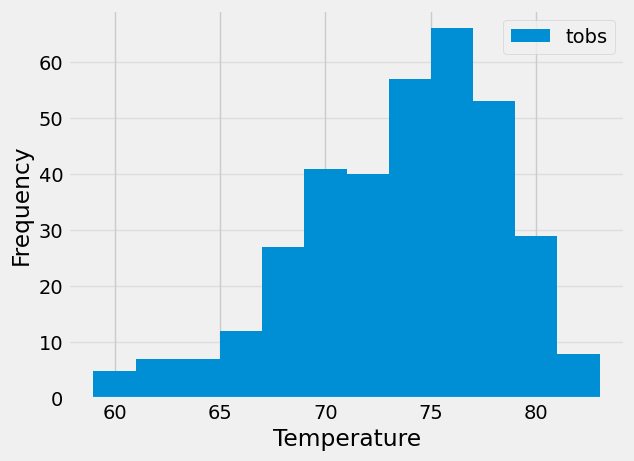

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = (session.query(measurement.date, measurement.tobs).filter(measurement.station == most_active_station_id, measurement.date >= one_year_ago).order_by(measurement.date).all())
temperature_df = pd.DataFrame(temperature_data, columns=["Date", "Temperature"])
plt.hist(temperature_df["Temperature"], bins=12, label="tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.5)
plt.legend()
plt.show()

# Close Session

In [23]:
# Close Session
session.close()